# Load Model
El notebook se encarga de tomar hiperparametros y los pesos de los mejores modelos y así poder demostrar la capacidad generativa de los modelos resultantes.

nota:
Para hacer finetunning se sugiere crear otro script/notebook aparte para así mantener modularidad.

In [1]:
# 02_main.ipynb
from grav_lens import get_datasets

from utils.model import create_model
from utils.loadsave import load_model_with_hyperparameters, load_hyperparameters, save_hyperparameters
from utils.optimize import dimensions, default_parameters

from functools import partial
import time
import pickle

import matplotlib.pyplot as plt
import numpy as np

In [2]:
result_foder = "results_2_dani"

In [3]:
import os 
# mi carpeta data se encuentra en el root
home_data = os.path.join("..", "..")
# Ejemplo de uso
# INDEX 0 es una carpeta de datasets mucho mas chica
train_dataset, val_dataset, test_dataset = get_datasets(data_index='1', max_files=60, home=home_data)

for X, Y in train_dataset.take(1):  # Mostrar un batch de entrenamiento
    print("Train X:", X.shape)
    print("Train Y:", Y.shape)

for X, Y in val_dataset.take(1):  # Mostrar un batch de validación
    print("Val X:", X.shape)
    print("Val Y:", Y.shape)

for X, Y in test_dataset.take(1):  # Mostrar un batch de prueba
    print("Test X:", X.shape)
    print("Test Y:", Y.shape)


Using data folder: ..\..\data\1
Train X: (32, 128, 128, 3)
Train Y: (32, 128, 128, 1)
Val X: (12, 128, 128, 3)
Val Y: (12, 128, 128, 1)
Test X: (6, 128, 128, 3)
Test Y: (6, 128, 128, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
(6, 128, 128, 1)
(3, 128, 128, 1)


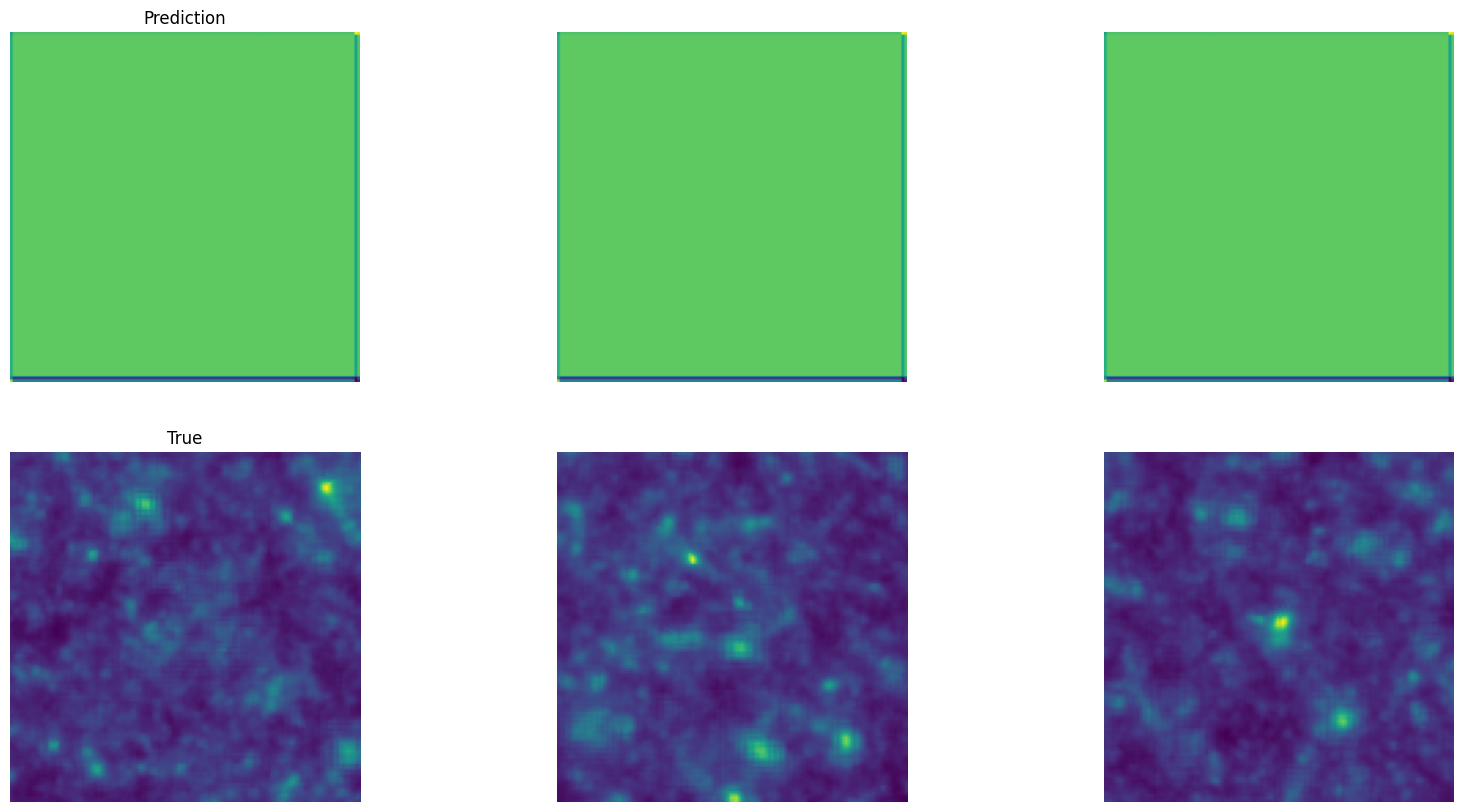

In [27]:
# notar cual numero estamos eligiendo

model = load_model_with_hyperparameters(
    4, 
    create_model=create_model, home_json=result_foder)

# model.summary()

for X, Y in test_dataset.take(1):
    prediction = model.predict(X)
print(prediction.shape)


# Obtener la primera imagen de la predicción
start = 3
end = start + 3
predicted_images = prediction[start:end]
true_images = Y[start:end]
print(predicted_images.shape)

# Configurar la figura
fig, axes = plt.subplots(2, predicted_images.shape[0], figsize=(20, 10))
axes = axes.flatten()

# Graficar cada imagen predicha
for i, (img_pred, img_true) in enumerate(zip(predicted_images, true_images)):
    axes[i].imshow(img_pred)  # Mostrar imagen predicha
    axes[i].axis('off')
    if i == 0:
        axes[i].set_title("Prediction")
    
    axes[i + predicted_images.shape[0]].imshow(img_true)  # Mostrar imagen verdadera
    axes[i + predicted_images.shape[0]].axis('off')
    if i == 0:
        axes[i + predicted_images.shape[0]].set_title("True")

plt.show()


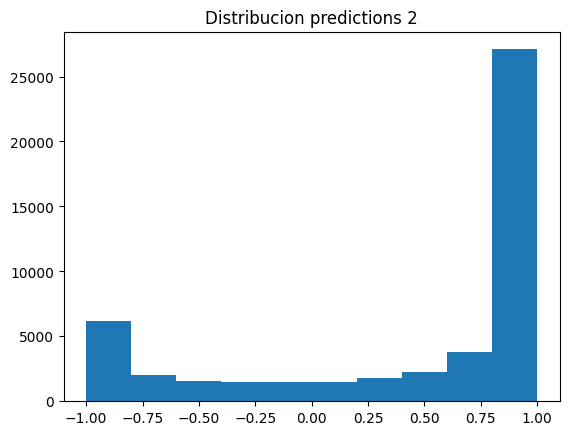

In [22]:

plt.hist(predicted_images.flatten())
plt.title("Distribucion predictions 2")
plt.show()

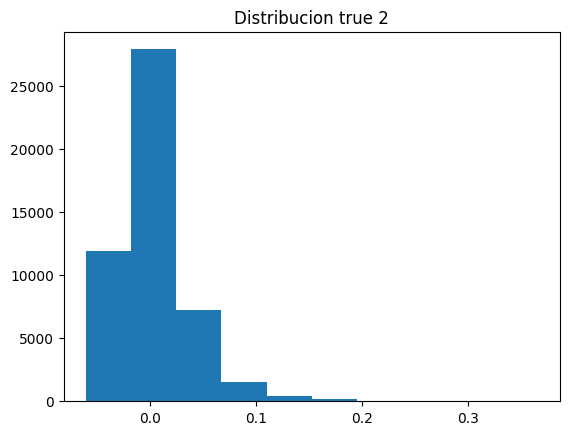

In [23]:
plt.hist(true_images.numpy().flatten())
plt.title("Distribucion true 2")
plt.show()

Correr la predicción

# Load Optimization Results


In [5]:
import pickle
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D


# 02_main.ipynb
from grav_lens import get_datasets

from utils.model import create_model
from utils.loadsave import load_model_with_hyperparameters, load_hyperparameters, save_hyperparameters
from utils.optimize import dimensions, default_parameters


from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.callbacks import CheckpointSaver
import time
import pickle

from tensorflow.keras import backend as K

from functools import partial


# es necesario cargar la misma F_objective
best_loss = float('inf')
counter = 1
@use_named_args(dimensions=dimensions)
def F_objective(learning_rate, 
     in_activation, h_activation, out_activation, 
     h_kernel_size, hidden_filters, 
     out_kernel_size, weight_kl, 
     beta_1, beta_2, epsilon, amsgrad, 
     decay_steps, decay_rate, epochs):
    """
    Función objetivo para la optimización de hiperparámetros.
    """
    global best_loss, counter
    model = create_model(learning_rate, 
                        in_activation, h_activation, 
                        out_activation, h_kernel_size, 
                        hidden_filters, out_kernel_size, 
                        weight_kl, beta_1, beta_2, 
                        epsilon, amsgrad, 
                        decay_steps, decay_rate)

    model.fit(train_dataset, epochs=epochs, verbose=True)

    loss = model.evaluate(val_dataset, verbose=False)

    print(f"\nLoss: {loss:.2%}\n")

    if loss < best_loss:
        model.save_weights(f'best_model_{counter}.weights.h5')
        save_hyperparameters(
            learning_rate, in_activation, 
            h_activation, out_activation, 
            h_kernel_size, hidden_filters, 
            out_kernel_size, weight_kl, 
            beta_1, beta_2, epsilon, 
            amsgrad, decay_steps, 
            decay_rate, counter
        )
        print(f"Model weights and hyperparameters saved with ID: {counter}")
        counter += 1
        best_loss = loss

    K.clear_session()
    return loss

In [7]:

# Cargar el objeto desde un archivo .pkl
from os.path import join

with open(join(result_foder,'optimization_results.pkl'), 'rb') as file:
    res = pickle.load(file)

# Ahora 'data' contiene el objeto cargado desde el archivo .pkl
print(res)

          fun: 0.03812620788812637
            x: [0.0006287608261952666, 'sigmoid', 'sigmoid', 'relu', 5, 46, 7, 0.06520235535315982, 0.8203556168159303, 0.15558005063355992, 2.7742815780300855e-05, False, 8410, 0.9232016808113246, 21]
    func_vals: [ 3.128e-01  5.987e-02 ...  2.784e-01  4.836e-02]
      x_iters: [[0.0001, 'sigmoid', 'sigmoid', 'sigmoid', 3, 64, 3, 0.1, 0.9, 0.99, 1e-07, False, 10000, 0.96, 10], [0.004206894649696163, 'sigmoid', 'relu', 'relu', 2, 17, 4, 0.18174557196886237, 0.7625931245276684, 0.8938820611861577, 1.6256711253140482e-05, True, 29074, 0.9196955613096589, 12], [1.984545490341773e-05, 'tanh', 'sigmoid', 'sigmoid', 4, 56, 3, 0.016618555883918976, 0.8401640258482737, 0.211336315739576, 2.199230055970545e-07, False, 22588, 0.8136775100744796, 8], [2.8926317509329233e-05, 'tanh', 'relu', 'sigmoid', 7, 32, 5, 0.05158057033049997, 0.9700871522712354, 0.8686836948369172, 1.4226004022888166e-07, False, 37237, 0.9810660574689165, 23], [0.0006287608261952666, 'si

Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='normalize'),
       Categorical(categories=('relu', 'sigmoid', 'tanh'), prior=None),
       Categorical(categories=('relu', 'sigmoid', 'tanh'), prior=None),
       Categorical(categories=('relu', 'sigmoid', 'tanh'), prior=None),
       Integer(low=2, high=7, prior='uniform', transform='normalize'),
       Integer(low=16, high=128, prior='uniform', transform='normalize'),
       Integer(low=2, high=7, prior='uniform', transform='normalize'),
       Real(low=0.01, high=2.0, prior='log-uniform', transform='normalize'),
       Real(low=0.0, high=0.99, prior='uniform', transform='normalize'),
       Real(low=0.0, high=0.999, prior='uniform', transform='normalize'),
       Real(low=1e-08, high=0.0001, prior='log-uniform', transform='normalize'),
       Categorical(categories=(True, False), prior=None),
       Integer(low=1000, high=50000, prior='uniform', transform='normalize'),
       Real(low=0.8, high=0.99, prior='uniform',

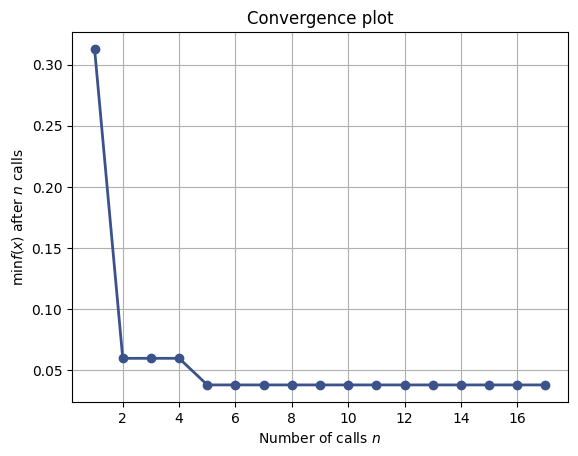

In [8]:
plot_convergence(res)
print(res.space)
print(res.x)
print("Accuracy: ", res.fun)

In [9]:
# para obtener la lista de nombres
# cada uno tiene un metodo .name, por tanto iteramos un for loop
dimension_names = [obj.name for obj in dimensions]
print(dimension_names)

['learning_rate', 'in_activation', 'h_activation', 'out_activation', 'h_kernel_size', 'hidden_filters', 'out_kernel_size', 'weight_kl', 'beta_1', 'beta_2', 'epsilon', 'amsgrad', 'decay_steps', 'decay_rate', 'epochs']


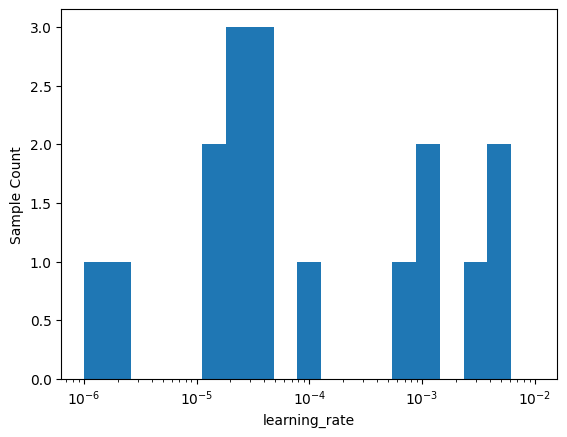

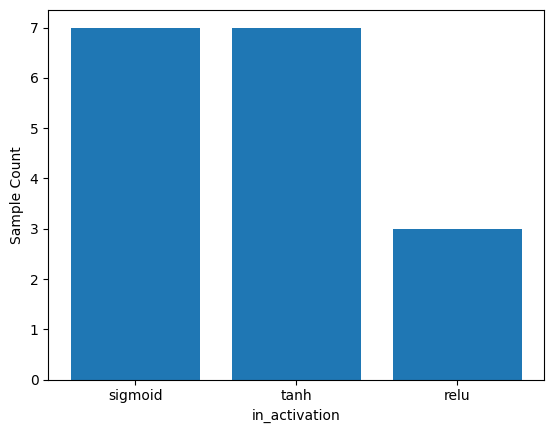

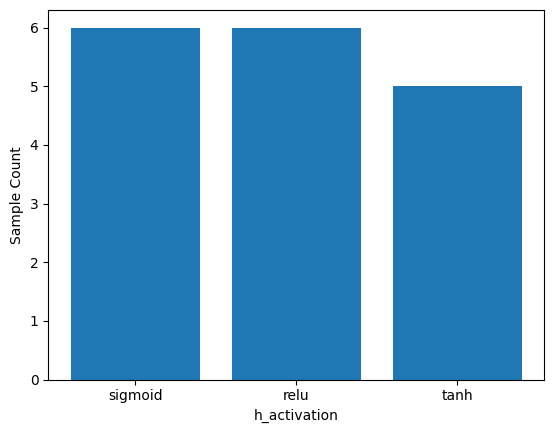

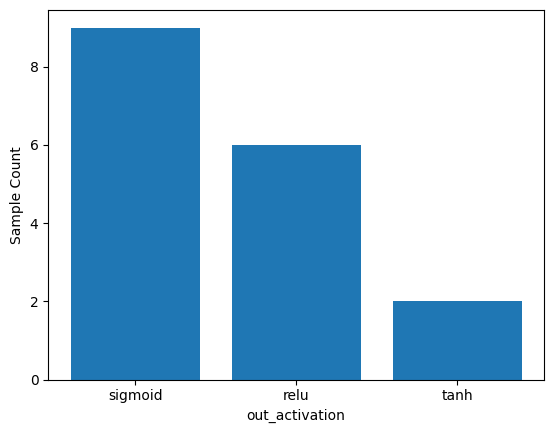

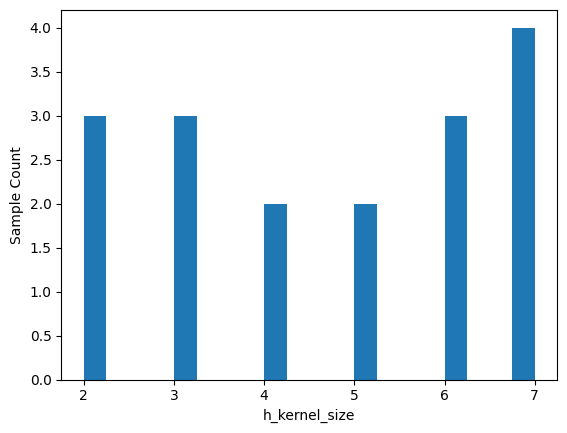

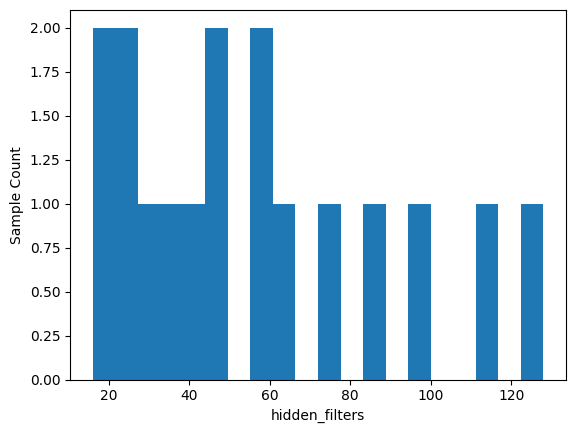

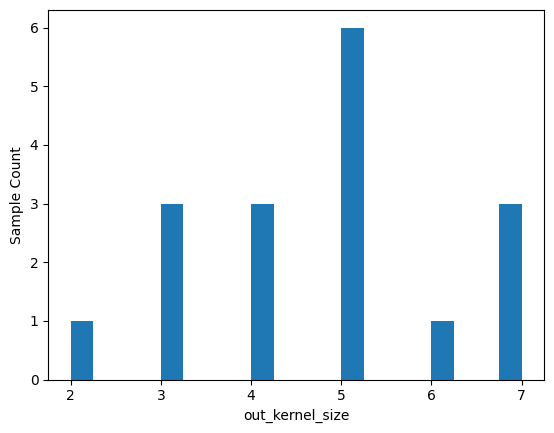

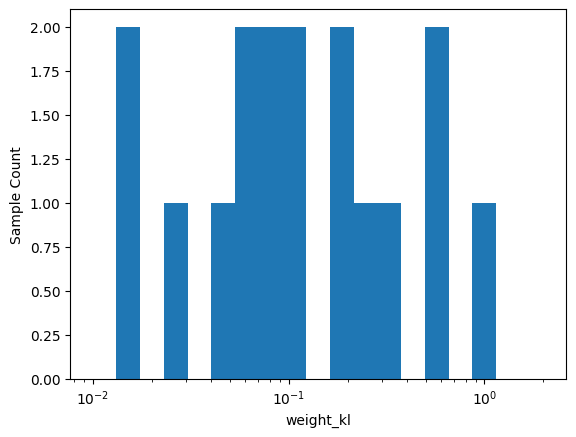

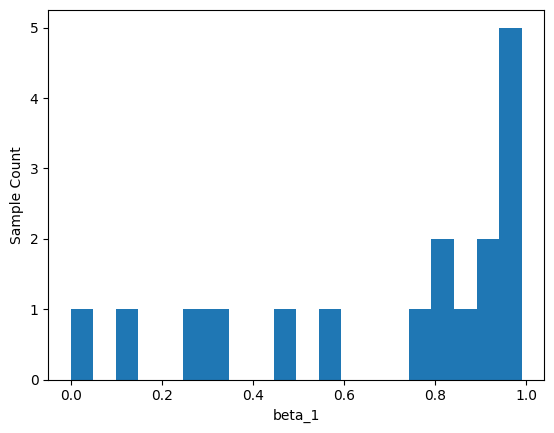

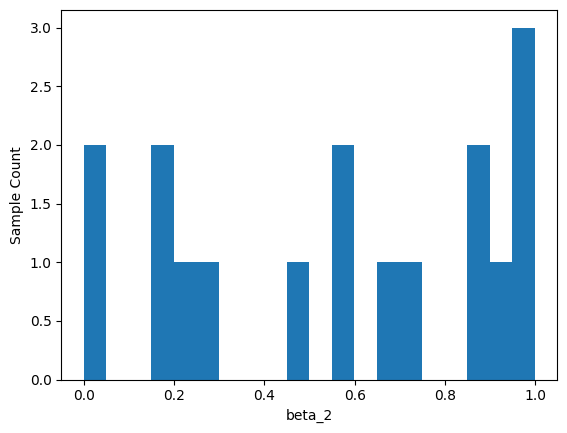

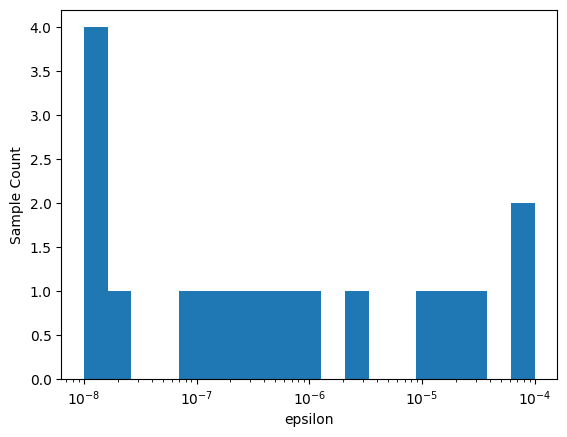

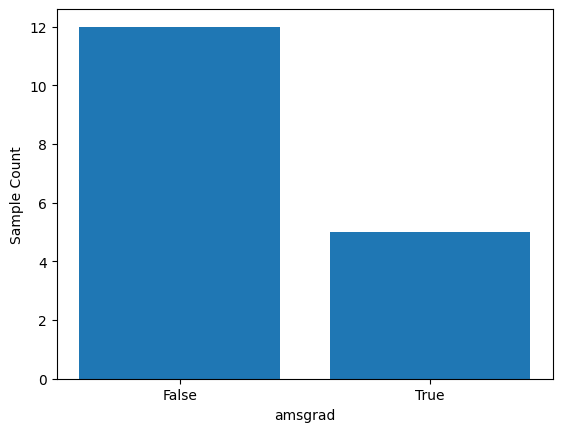

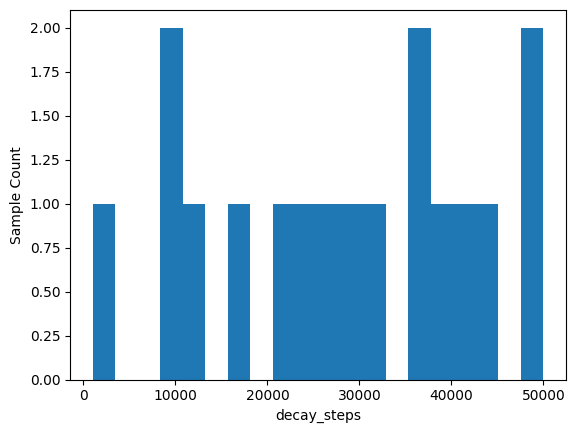

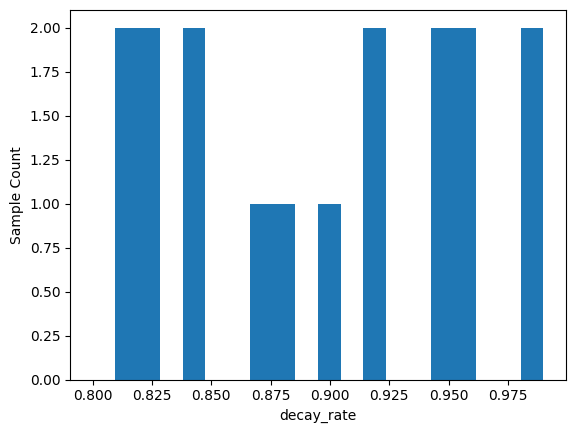

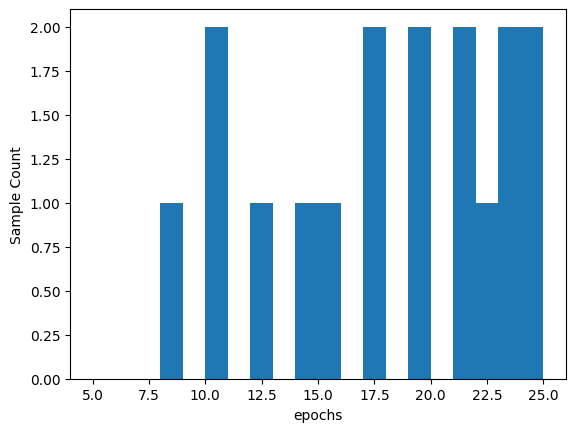

In [10]:
# genera varios histogramas
for dimension_identifier in dimension_names:
    plot_histogram(result=res,  dimension_identifier=dimension_identifier)
    plt.show()

In [ ]:
, , 'out_activation', 'h_kernel_size', 'hidden_filters', 'out_kernel_size'

<Axes: xlabel='in_activation', ylabel='h_activation'>

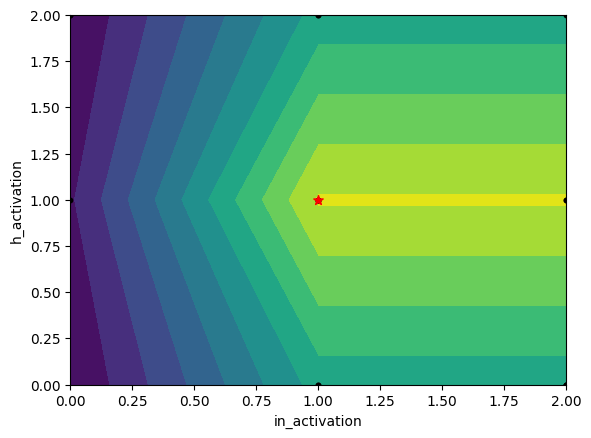

In [14]:
plot_objective_2D(res, 'in_activation', 'h_activation' )

In [16]:
important_dim = ['learning_rate',
 'in_activation',
 'h_activation',
 'out_activation',
 'h_kernel_size',
 'hidden_filters',
 'out_kernel_size',
 'weight_kl']

<Axes: >

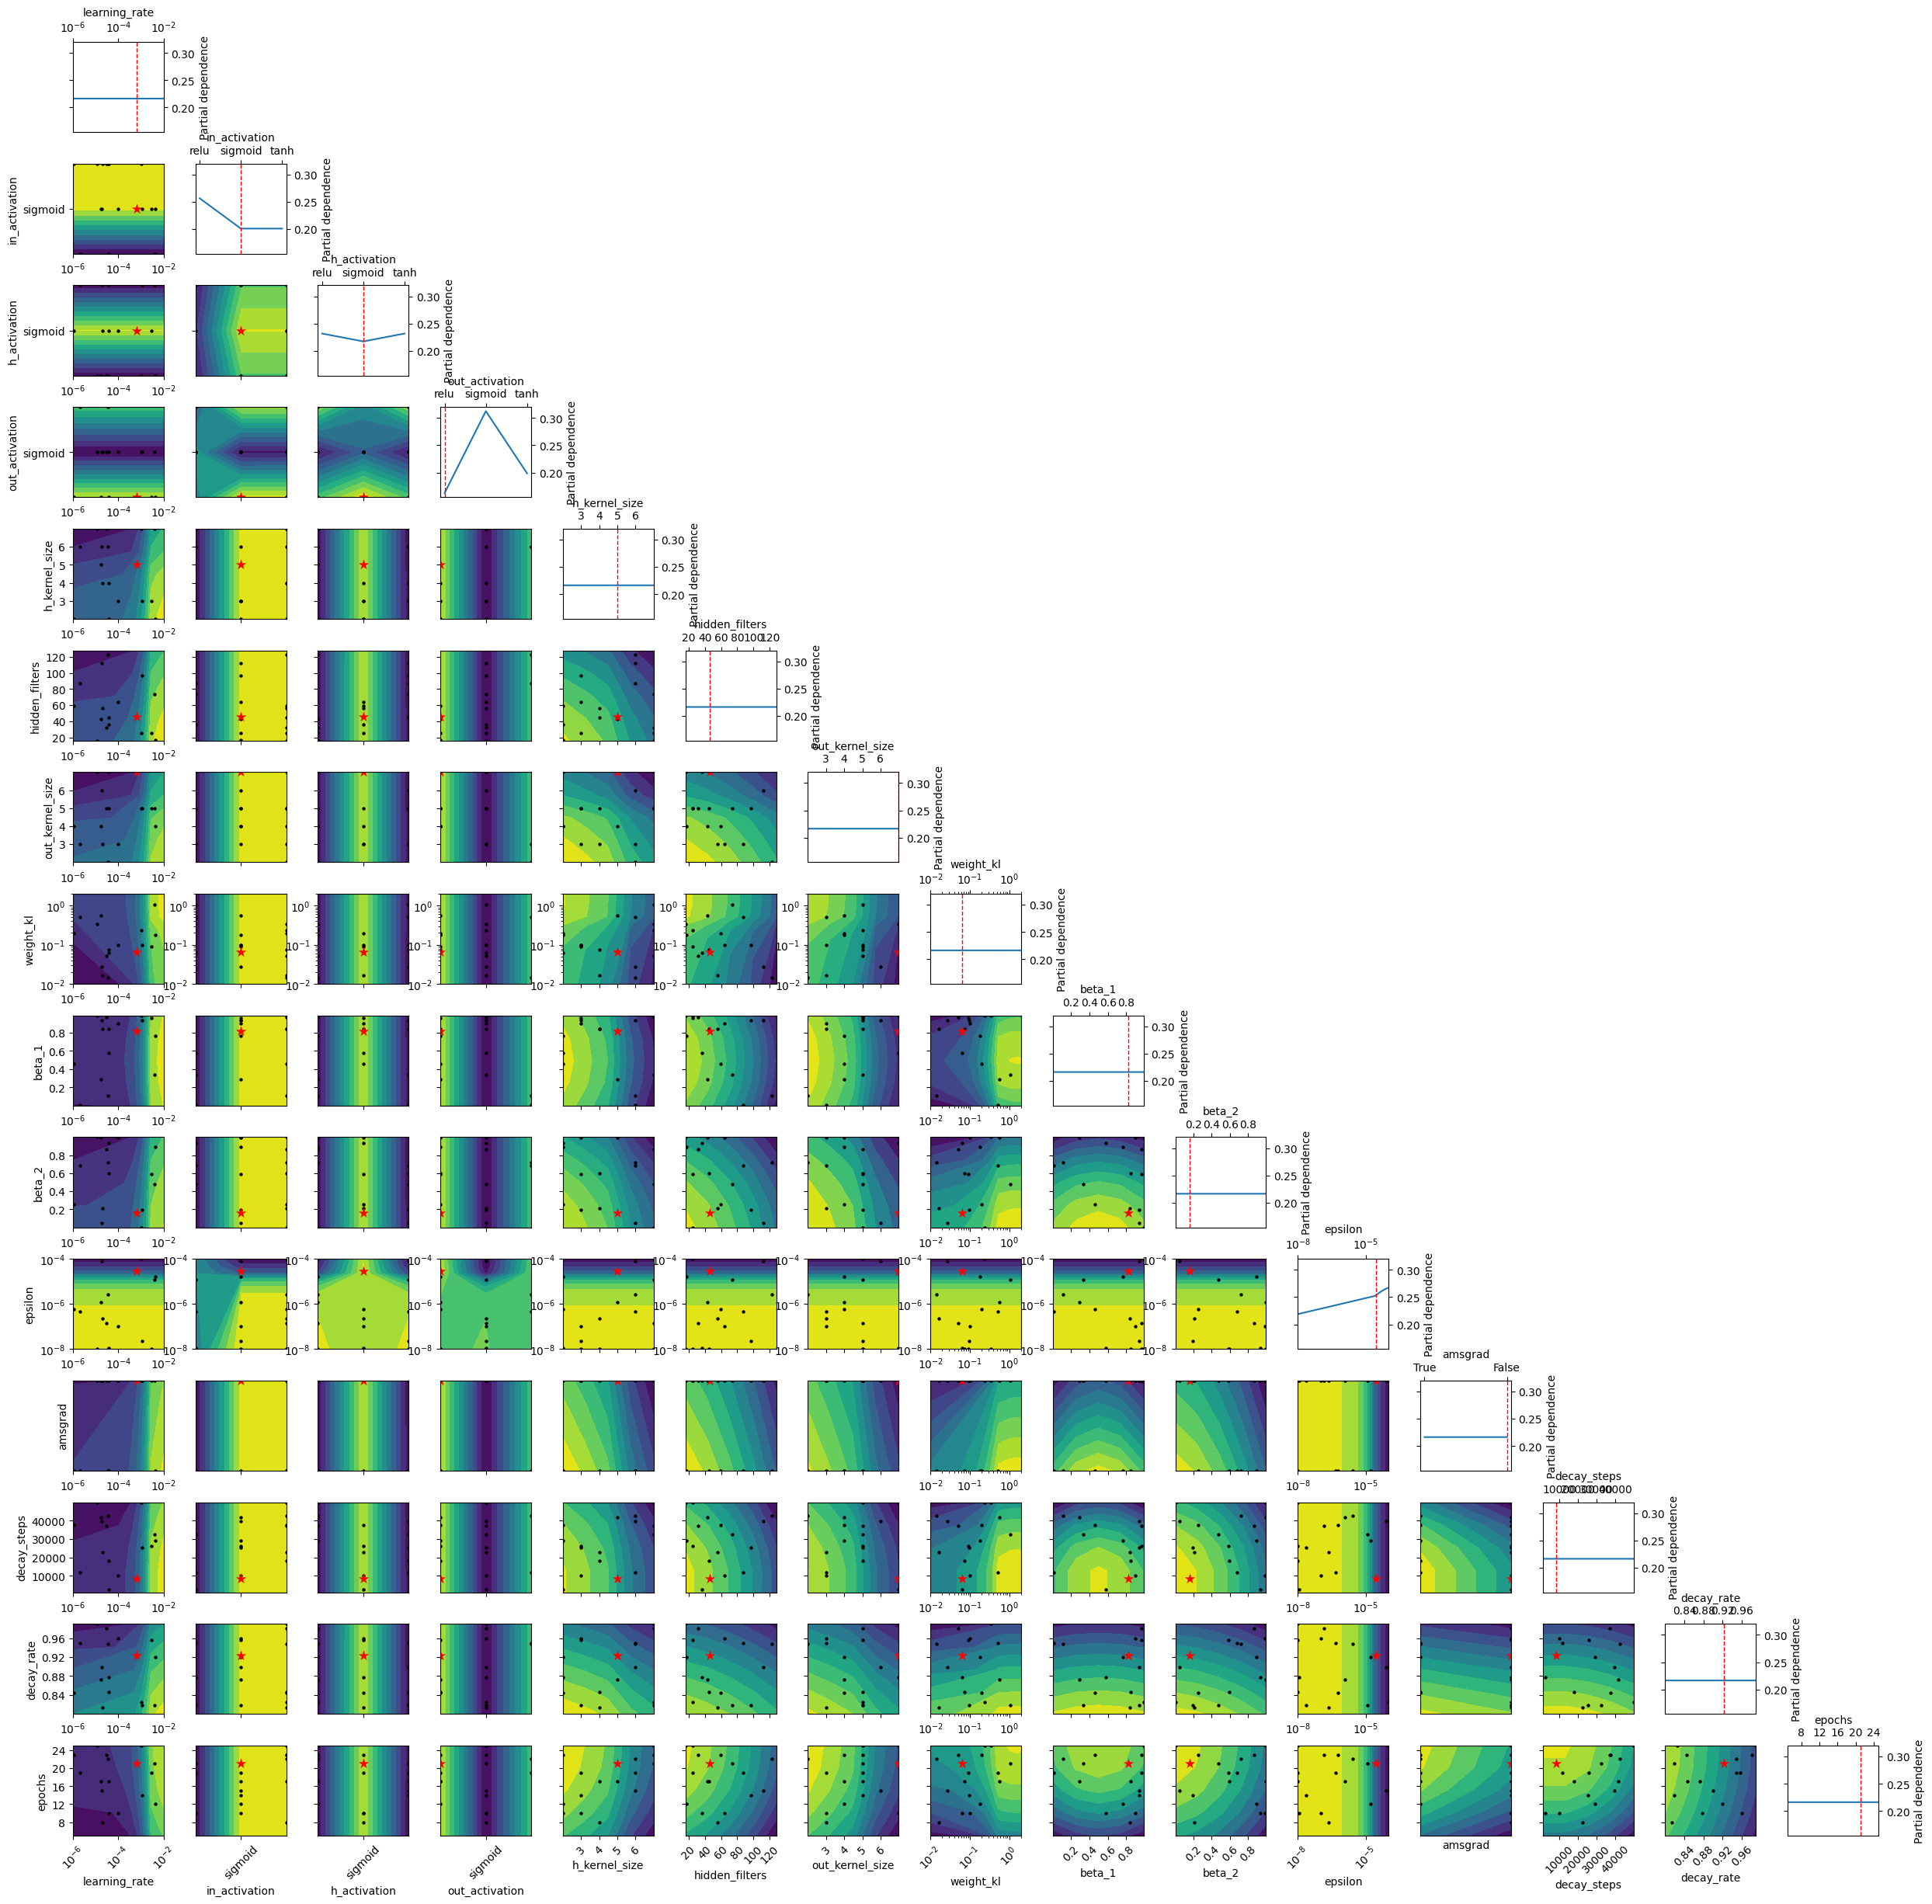

In [23]:
plot_objective(result=res, n_points=5)